# Время до метро и округления 

In [462]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import seaborn as sns             # ещё один пакет для картинок 
import ast

plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

In [463]:
import plotly 

import plotly_express as px
import plotly.graph_objects as go 

from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

In [464]:
df = pd.read_csv("data/cian_v2.tsv", sep='\t')
df = df[df['Тип жилья'] == 'Вторичка']

df.drop_duplicates(subset=['lat', 'long'], inplace=True)
print(df.shape)

(11709, 50)


## Расстояния до метро

__Гипотеза:__ люди сильно врут, когда указывают время, в течение которого можно добраться до метро от квартиры. 

In [465]:
df_geo = df[['href', 'metro_walk_min', 'metro_auto_min', 'stations_walk', 'stations_auto',
    'google_center_dist', 'google_center_time_driving', 'google_stations_auto_walk_dist',
    'google_stations_auto_walk_time', 'google_stations_walk_walk_dist', 'google_stations_walk_walk_time']]

df_geo.head()

,href,metro_walk_min,metro_auto_min,stations_walk,stations_auto,google_center_dist,google_center_time_driving,google_stations_auto_walk_dist,google_stations_auto_walk_time,google_stations_walk_walk_dist,google_stations_walk_walk_time
0,https://www.cian.ru/sale/flat/200597045/,9.0,NaN,"Октябрьское поле,Зорге,Панфиловская",NaN,1921,14332,{},{},"{'Октябрьское поле': 662, 'Зорге': 428, 'Панфи...","{'Октябрьское поле': 859, 'Зорге': 599, 'Панфи..."
1,https://www.cian.ru/sale/flat/226507726/,NaN,1.0,NaN,NaN,1386,13441,{},{},{},{}
2,https://www.cian.ru/sale/flat/227088765/,7.0,NaN,Кропоткинская,NaN,817,4111,{},{},{'Кропоткинская': 994},{'Кропоткинская': 1235}
3,https://www.cian.ru/sale/flat/221495152/,12.0,6.0,"Тушинская,Спартак",Щукинская,1985,17522,{'Щукинская': 3452},{'Щукинская': 4475},"{'Тушинская': 1067, 'Спартак': 1650}","{'Тушинская': 1421, 'Спартак': 2158}"
5,https://www.cian.ru/sale/flat/224446374/,NaN,5.0,NaN,Ломоносовский проспект,1582,10946,{'Ломоносовский проспект': 652},{'Ломоносовский проспект': 868},{},{}


In [466]:
df_small = pd.DataFrame( )

def get_min_time(w):
    x = list(ast.literal_eval(w).values())
    if len(x) > 0:
        return  round(min(x)/60) # min(x)/60 #
    else:
        return np.nan

df_small['google_time'] = df_geo['google_stations_walk_walk_time'].apply(get_min_time)
df_small['cian_time'] = df_geo['metro_walk_min']
df_small['href'] = df_geo['href']
df_small = df_small.dropna()#.reset_index(drop=True)
print(df_small.shape)
df_small.head()

(9126, 3)


,google_time,cian_time,href
0,10.0,9.0,https://www.cian.ru/sale/flat/200597045/
2,21.0,7.0,https://www.cian.ru/sale/flat/227088765/
3,24.0,12.0,https://www.cian.ru/sale/flat/221495152/
6,6.0,4.0,https://www.cian.ru/sale/flat/205780760/
8,10.0,7.0,https://www.cian.ru/sale/flat/223279747/


In [481]:
qg = df_small.google_time.quantile(0.95)
qg = 20

df_small = df_small[(df_small.google_time < qg)&(df_small.cian_time < qg)]

# print(df_small.shape)
# plt.hist(df_small.google_time, alpha=0.4, label="google", density=True, bins=19)
# plt.hist(df_small.cian_time, alpha=0.4, label='cian', density=True, bins=19)
# plt.legend();

In [482]:
# Перед запуском убрать round! 

fig = go.Figure([
        go.Scatter(x=df_small["google_time"], y=df_small["cian_time"], 
                   text=df_small['href'],
                   mode='markers', marker_color='rgb(0, 100, 153)'),
        go.Scatter(x=[0,20], y=[0,20])
    ])

fig.show()

In [483]:
# import webbrowser
# import pandas as pd
# import plotly.graph_objs as go
# df = pd.DataFrame({'x': [1, 2, 3],
#                    'y': [1, 3, 2],
#                    'link': ['https://google.com', 'https://bing.com', 'https://duckduckgo.com']})

# fig = go.FigureWidget(layout={'hovermode': 'closest'})
# scatter = fig.add_scatter(x=df.x, y=df.y, mode='markers', marker={'size': 20})

# def do_click(trace, points, state):
#     if points.point_inds:
#         ind = points.point_inds[0]
#         url = df.link.iloc[ind]
#         webbrowser.open_new_tab(url)
        
# scatter.on_click(do_click)
# fig

In [484]:
df_ci = df_small.cian_time.value_counts().reset_index()
df_go = df_small.google_time.value_counts().reset_index()

fig = go.Figure([
        go.Bar(name = "Время до метро ЦИАН",
               marker={'color': 'rgb(0, 100, 153)'},
            y = df_ci['cian_time'], x = df_ci['index']),
    
        go.Bar(name = "Время до метро Google",
               y = df_go['google_time'], x = df_go['index'], text=df_go['index'])
        ])

fig.update_layout(title='До метро пешком (минуты)',
                 annotations=[dict(x=5, y=920, text="Люди любят округлять", 
                                  showarrow=True, arrowhead=5, ax=10, ay=-30)])


fig.show()

Проверим гипотезу! 

https://github.com/hse-econ-data-science/eds_spring_2020/blob/master/sem09_hypothesis/sem_09_hypo_187_188.ipynb

In [485]:
norm_rm = stats.norm()
norm_rm.pdf(0) # плотность распределния в точке 0

0.3989422804014327

In [486]:
norm_rm.cdf(0)  # F(0) = P(X <= 0)

0.5

In [487]:
norm_rm.ppf(0.05) # квантиль уровня 0.05

-1.6448536269514729

In [488]:
norm_rm.rvs(10)  # сгенерили выборку 

array([-0.64269518,  0.31994956, -1.36518283,  1.20559048, -0.2971542 ,
       -1.10814971,  0.65834243,  0.42854886,  0.18925332, -0.1846538 ])

In [489]:
from scipy import stats

# Задание: сделать дополнительный аргумент, который выбирает альтернативу 
# m_a != m_d  - two-sided
# m_a < m_d   - less
# m_a > m_d   - right

def norm_mean_test(mean_hat, std_hat, mu_0=0, alpha=0.05, margin=3):
    
    z_obs = (mean_hat - mu_0)/std_hat
    z_crit = stats.norm().ppf(1 - alpha/2)

    plt.figure(figsize = (10, 5))
    x = np.linspace(-margin, margin)
    
    pdf = stats.norm().pdf(x)

    plt.plot(x, pdf, color="black")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]

    # Критические и наблюдаемые значения статистки 
    statistics = ['-z_crit', 'z_crit', '-z_obs', 'z_obs']
    params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                   (z_crit, 0.05, z_crit, margin, 'b'),
                                   (-z_obs, -0.9, -margin, -z_obs, 'r'), 
                                   (z_obs, 0.3, z_obs, margin, 'r')]))                           
    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]
        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        plt.text(statistic + text_margin, 
                 0.8*y_max, round(statistic, 3), color=color, fontsize=16)
        xq = np.linspace(left_bound, right_bound)
        yq = stats.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)

    p_value = 2*stats.norm().cdf(-z_obs)
    
    return p_value

In [490]:
alpha = 0.05

n,_ = df_small.shape

diff = df_small.google_time.mean() - df_small.cian_time.mean()
diff_sd = np.sqrt(df_small.google_time.var()/n + df_small.cian_time.var()/n)

z_obs = diff/diff_sd
z_obs

65.1643703290228

In [491]:
z_crit = stats.norm().ppf(1 - alpha/2)
z_crit

1.959963984540054

In [492]:
diff

4.840337643678161

0.0012138254930994623

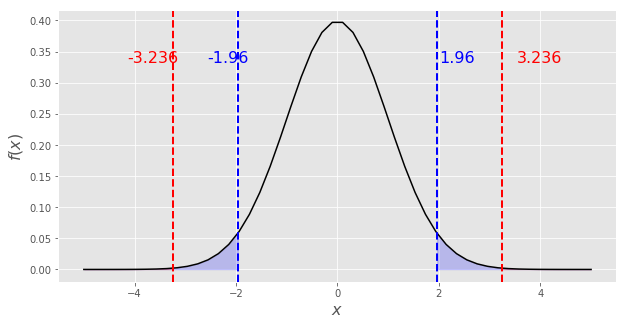

In [493]:
norm_mean_test(diff, diff_sd, mu_0=4.6, alpha=0.05, margin=5)

In [494]:
pd.Series([i%5 for i in range(20)]).value_counts()

4    4
3    4
2    4
1    4
0    4
dtype: int64

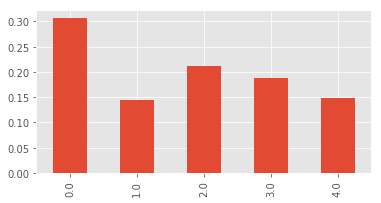

In [499]:
# Для людей 
x_cian = ((df_small.cian_time % 5).value_counts()/df_small.shape[0]).sort_index()
x_cian.plot(kind='bar', figsize=(6,3));

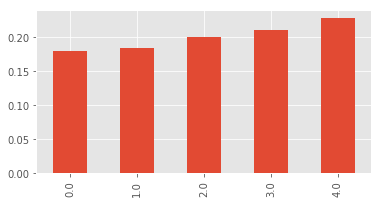

In [500]:
# Для гугла
x_google = ((df_small.google_time % 5).value_counts()/df_small.shape[0]).sort_index()
x_google.plot(kind='bar', figsize=(6,3));

Гипотеза: люди, когда они вбивают время до метро излишне сильно любят округлять, нам надо сравнивать вероятность возникновения нулевого остатка по сравнению с каким-то каноном. Взять канон из головы или теории мы не можем, равномерное распределение мы рассматривать тоже не можем, так как по гистограмме времени до метро четко виден перекос в правую сторону. 

Получается, что единственный выход, который вроде бы приходит в голову, это сравнить вероятность возникновения нулевого остатка в гугле, как каноне и в реальных даннных. 

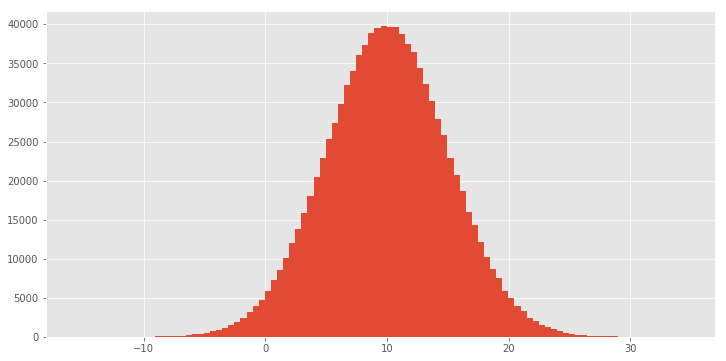

In [454]:
norm_rv = stats.expon(scale=5) #loc=10, scale=5)
norm_rv = stats.norm(loc=10, scale=5)

x = norm_rv.rvs(size=10**6)
plt.hist(x, bins=100);

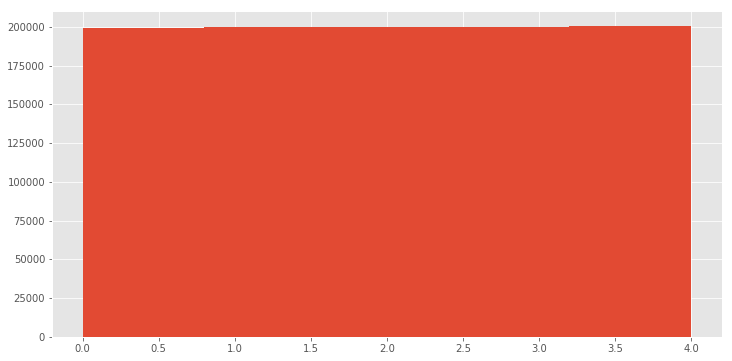

In [455]:
y = np.round(x) % 5
plt.hist(y, bins=5);